# Part 3: Post Processing Visualization

In this part, we will still focus on EDA but more based on visualizations of the data to find potential relationships between features and our target variable `log_bike_count`.

After conducting thorough feature engineering on our bike dataset, this notebook focuses on an in-depth visualization analysis. The goal here is to gain deeper insights into the relationships between different features and our target variable, `log_bike_count`.

We will explore spatial distributions, temporal patterns, and correlations between various factors such as `weather` conditions, `seasons`, `holidays`, and `working days`. This will help us understand the dynamics influencing bike traffic in Paris.

Additionally, we will investigate any potential outliers and their impact on the data. These visualizations will not only provide us with valuable insights for model building but also help in validating the effectiveness of our feature engineering efforts.

In [1]:
# imports

from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
from IPython.display import display
from IPython import get_ipython

plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)
sns.set_palette("tab10")

In [2]:
# Load the processed train dataset
bike_df = pd.read_parquet(Path("data") / "train_processed_viz.parquet")
bike_df.head()

,year,weather,rush_hour,stay_at_home_code,wspd,school_holiday,coco,log_bike_count,pres,temp,...,counter_name,snow,season,masks_code,bike_count,dwpt,wpgt,rhum,hour,month
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 02:00:00,2020,Clear,0,0,3.6,0,1.0,0.000000,1019.9,13.0,...,28 boulevard Diderot E-O,0.108375,Fall,0,0.0,9.4,9.3,79.0,2,9
2020-09-01 03:00:00,2020,Clear,0,0,5.4,0,1.0,0.693147,1019.8,12.9,...,28 boulevard Diderot E-O,0.000000,Fall,0,1.0,9.7,5.0,81.0,3,9
2020-09-01 04:00:00,2020,Clear,0,0,5.4,0,1.0,0.000000,1019.5,12.4,...,28 boulevard Diderot E-O,0.108375,Fall,0,0.0,9.6,7.4,83.0,4,9
2020-09-01 15:00:00,2020,Windy,0,0,14.8,0,3.0,1.609438,1017.5,19.8,...,28 boulevard Diderot E-O,0.000000,Fall,0,4.0,7.8,28.0,46.0,15,9
2020-09-01 18:00:00,2020,Clear,1,0,11.2,0,4.0,2.302585,1017.6,18.9,...,28 boulevard Diderot E-O,0.000000,Fall,0,9.0,7.0,24.0,46.0,18,9


## Time Series Visualization

To get an overall idea of the evolution of our target variable `log_bike_count` over our time period, we can make a general plot.

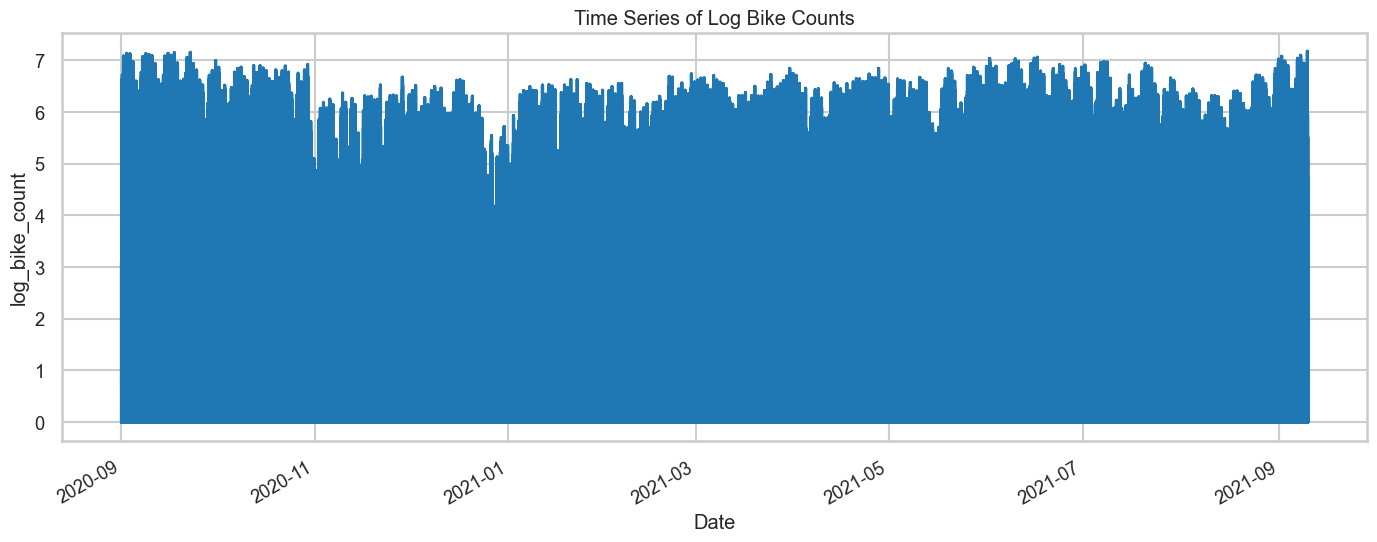

In [3]:
# Plotting bike counts over time
plt.figure(figsize=(15, 6))
bike_df['log_bike_count'].plot()
plt.title('Time Series of Log Bike Counts')
plt.xlabel('Date')
plt.ylabel('log_bike_count')
plt.show()

However, it is a bit difficult to get any meaningful observation from this general plot. We can observe some kind of pattern (perhaps seasonality) and noticeable drops around November 2020 and January 2021, which we assume to be consequence of lockdown measures by the French government.

It might be more interesting to look more closely at the temporal distribution of bike counts at a particular station. As we've seen above, plotting all the stations isn't very efficient as we cannot not see much due to the large number of data points. In particular, we will look at the busiest counter. 

In [4]:
#Count the total number of bikes per counter
grouped_df = bike_df.groupby('counter_name')['log_bike_count'].sum().reset_index()

# Sort the DataFrame in descending order based on the sum
sorted_df = grouped_df.sort_values(by='log_bike_count', ascending=False)
sorted_df.head()

,counter_name,log_bike_count
49,Totem 73 boulevard de Sébastopol S-N,41422.843273
48,Totem 73 boulevard de Sébastopol N-S,39508.928841
47,Totem 64 Rue de Rivoli O-E,38267.793364
20,67 boulevard Voltaire SE-NO,36535.491212
9,27 quai de la Tournelle SE-NO,35132.133180


The most frequented bike counter is `Totem 73 boulevard de Sébastopol S-N`. Let's look at the distribution of `log_bike_count` at this counter.

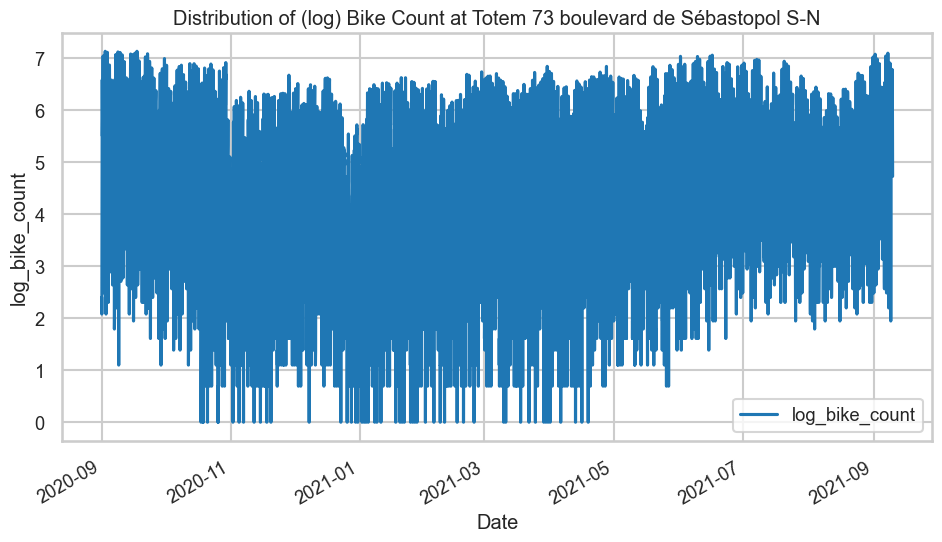

In [5]:
mask = bike_df["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

filtered_bike_df = bike_df.loc[mask]

# Plotting
ax = filtered_bike_df.plot(y="log_bike_count", figsize=(10, 6))  # Adjust the figure size if needed
ax.set_xlabel('Date')
ax.set_ylabel('log_bike_count')
ax.set_title('Distribution of (log) Bike Count at Totem 73 boulevard de Sébastopol S-N')

# Show the plot
plt.show()

It is still very hard to discern any pattern as there are still a lot of spikes. Instead we will aggregate the data by week to have a clearer overall picture.

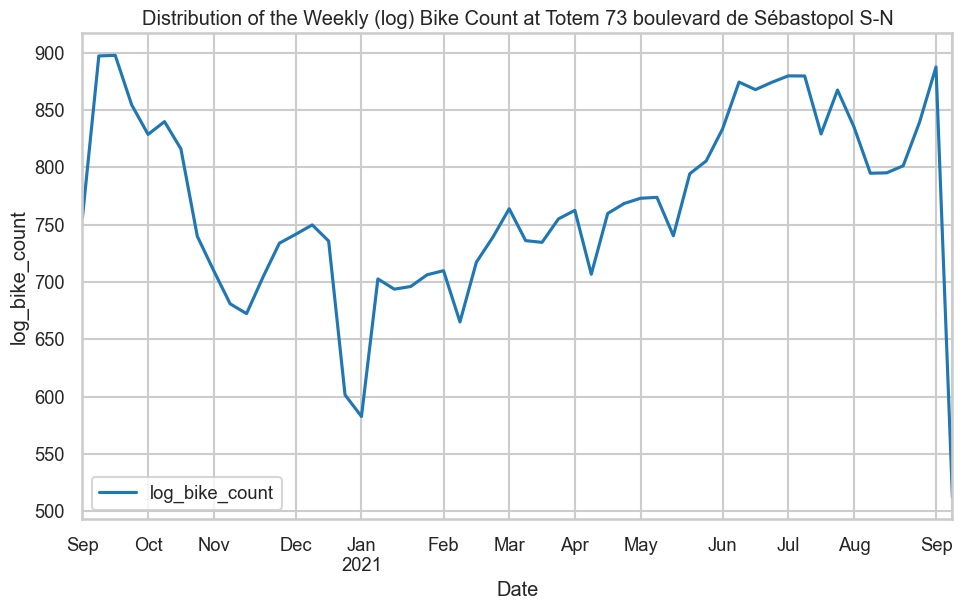

In [6]:
mask = bike_df["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

filtered_bike_df = bike_df.loc[mask]

# Group by 1-week frequency and sum the 'bike_count' for each week
weekly_sum = filtered_bike_df.groupby(pd.Grouper(freq="1w")).agg({'log_bike_count': 'sum'})

ax = weekly_sum.plot(y="log_bike_count", figsize=(10, 6))  # Adjust the figure size if needed
ax.set_xlabel('Date')
ax.set_ylabel('log_bike_count')
ax.set_title('Distribution of the Weekly (log) Bike Count at Totem 73 boulevard de Sébastopol S-N')

# Show the plot
plt.show()

The picture is already a lot clearer. We can make a first observation that there is a decrease in bike counts as we move in the Winter season and then starts increasing again in Spring until it reaches a peak in Summer.

We can also zoom on a week in particular for a more short-term visualization and potentially observe trends on a more focused scale.

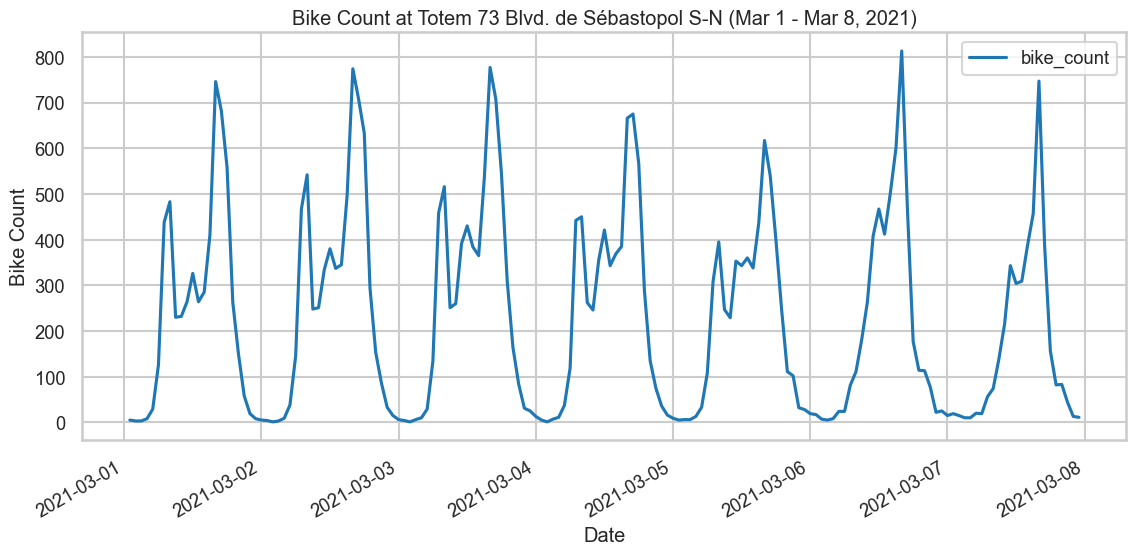

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

mask = (
    (bike_df["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (bike_df.index > pd.to_datetime("2021-03-01"))
    & (bike_df.index < pd.to_datetime("2021-03-08"))
)

bike_df[mask].plot(y="bike_count", ax=ax)

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Bike Count')
ax.set_title('Bike Count at Totem 73 Blvd. de Sébastopol S-N (Mar 1 - Mar 8, 2021)')

# Show the plot
plt.show()

It is obvious that there is a periodic pattern in a single week. We would need to look at every hour to see in better detail the evolution of the number of bikes in a day.

However, before looking at the hourly distribution, we will look at more general seasonality factors like the `Season`, `Weather`, and whether the time corresponds to a `Working Day` or is during `Rush Hours`.

## Distribution vs. Season,  Weather, Working Day, Rush Hours

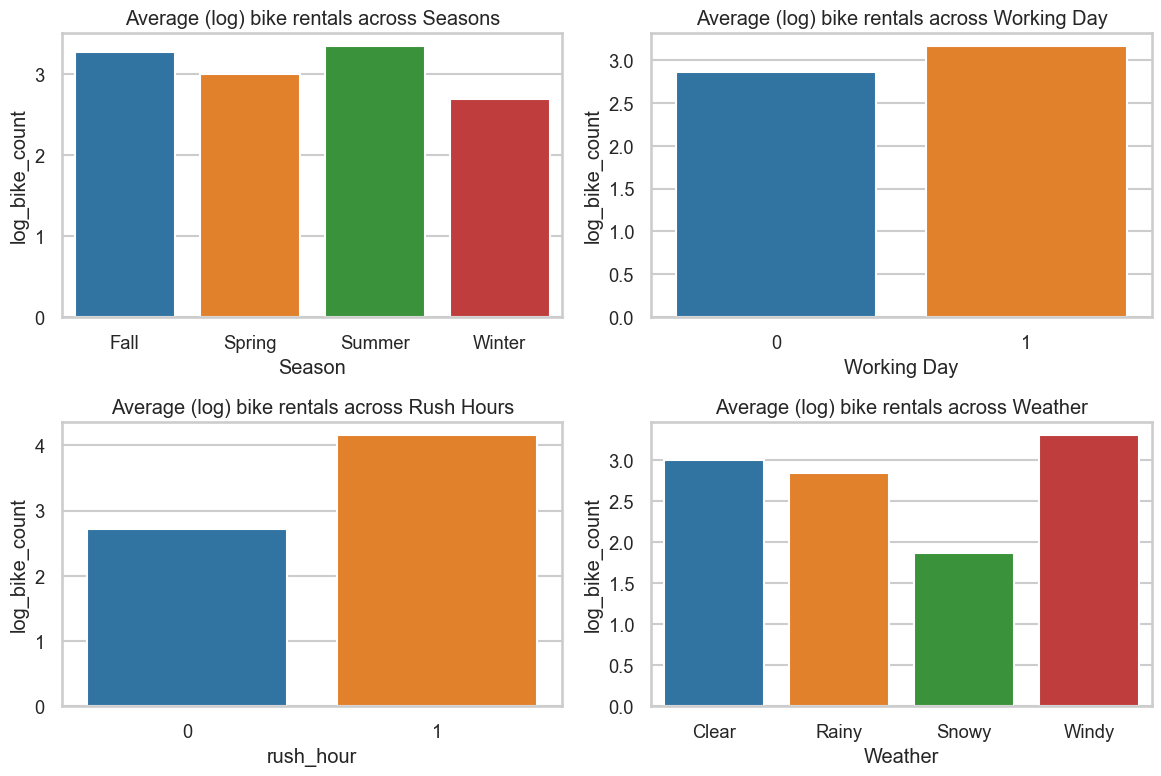

In [8]:
# Average values across each of the categorical columns 
fig = plt.figure(figsize=(12, 8))

axes = fig.add_subplot(2, 2, 1)
group_season = pd.DataFrame(bike_df.groupby(['season'])['log_bike_count'].mean()).reset_index()
sns.barplot(data=group_season, x='season', y='log_bike_count', ax=axes)
axes.set(xlabel='Season', ylabel='log_bike_count', title='Average (log) bike rentals across Seasons')

axes = fig.add_subplot(2, 2, 2)
group_workingday = pd.DataFrame(bike_df.groupby(['working_day'])['log_bike_count'].mean()).reset_index()
sns.barplot(data=group_workingday, x='working_day', y='log_bike_count', ax=axes)
axes.set(xlabel='Working Day', ylabel='log_bike_count', title='Average (log) bike rentals across Working Day')

axes = fig.add_subplot(2, 2, 3)
group_season = pd.DataFrame(bike_df.groupby(['rush_hour'])['log_bike_count'].mean()).reset_index()
sns.barplot(data=group_season, x='rush_hour', y='log_bike_count', ax=axes)
axes.set(xlabel='rush_hour', ylabel='log_bike_count', title='Average (log) bike rentals across Rush Hours')


axes = fig.add_subplot(2, 2, 4)
group_weather = pd.DataFrame(bike_df.groupby(['weather'])['log_bike_count'].mean()).reset_index()
sns.barplot(data=group_weather, x='weather', y='log_bike_count', ax=axes)
axes.set(xlabel='Weather', ylabel='log_bike_count', title='Average (log) bike rentals across Weather')

plt.tight_layout()
plt.show()

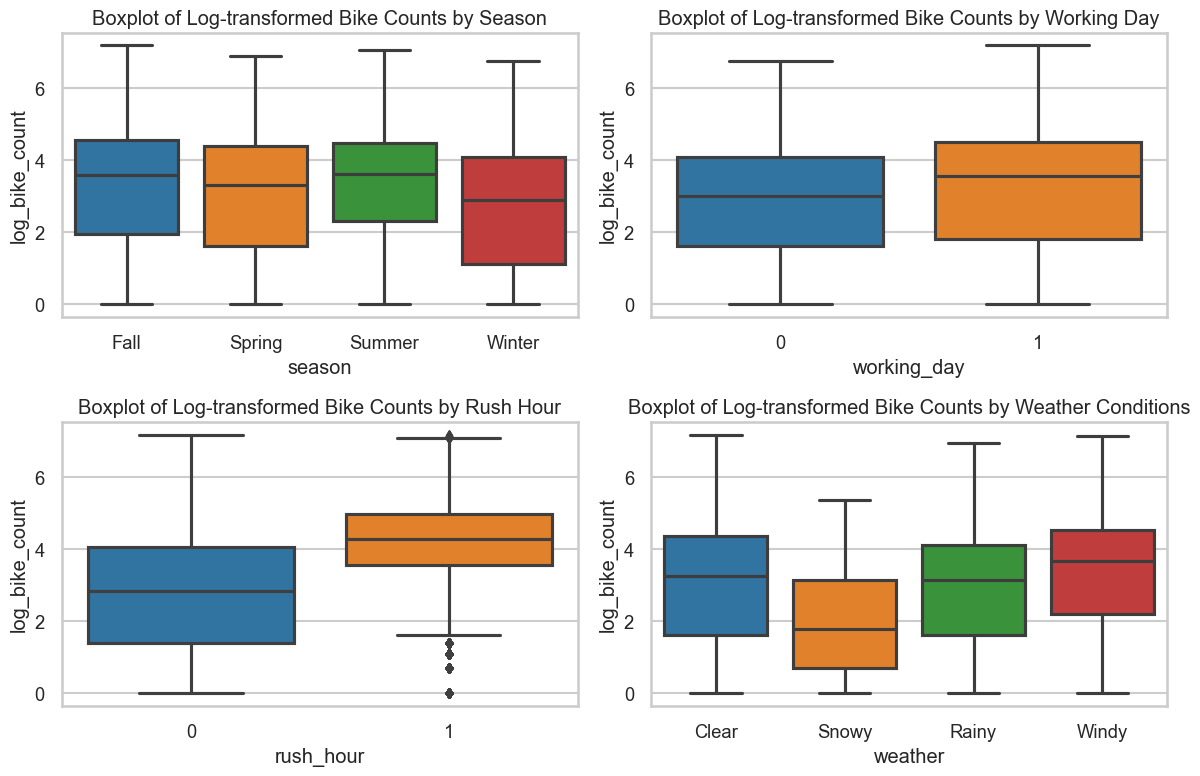

In [9]:
# Seaborn boxplots to get an idea of the distribution/outliers
f, axes = plt.subplots(2, 2, figsize=(12, 8))

hue_order= ['Fall', 'Spring', 'Summer', 'Winter']
sns.boxplot(data=bike_df, y='log_bike_count', x='season', ax=axes[0][0], order=hue_order)
axes[0][0].set_title("Boxplot of Log-transformed Bike Counts by Season")

sns.boxplot(data=bike_df, y='log_bike_count', x='working_day', ax=axes[0][1])
axes[0][1].set_title("Boxplot of Log-transformed Bike Counts by Working Day")

sns.boxplot(data=bike_df, y='log_bike_count', x='rush_hour', ax=axes[1][0])
axes[1][0].set_title("Boxplot of Log-transformed Bike Counts by Rush Hour")

hue_order= ['Clear', 'Snowy', 'Rainy', 'Windy']
sns.boxplot(data=bike_df, y='log_bike_count', x='weather', ax=axes[1][1], order=hue_order)
axes[1][1].set_title("Boxplot of Log-transformed Bike Counts by Weather Conditions")

plt.tight_layout()
plt.show()

#### Observations:

- More bikers during Summer and Fall season, noticeably lower during Winter.
- More bikers during working days (vs weekend and holiday). This makes sense, as regular bikers are using bikes to go to work.
- More bikers during clear (makes sense) and windy (surprising) weather. One reason could be that in Paris, regular bikers will still take the bike even on windy days. However, it's clear that whenever it snows, there are less bikes.
- More bikers during Rush hour (not surprising) as most regular bikers are using bikes during those times.

## Lockdown Dates

`stay_at_home`:

- 0.0 - No data available for that date.
- 1.0 - recommend not leaving house.
- 2.0 - require not leaving house with exceptions for daily exercise, grocery shopping, and 'essential' trips.
- 3.0 - require not leaving house with minimal exceptions (eg allowed to leave once a week, or only one person can leave at a time, etc.

`masks`:

- 0.0 - No policy.
- 1.0 - Recommended.
- 2.0 - Required in some specified shared/public spaces outside the home with other people present, or some situations when social distancing not possible.
- 3.0 - Required in all shared/public spaces outside the home with other people present or all situations when social distancing not possible.
- 4.0 - Required outside the home at all times regardless of location or presence of other people.


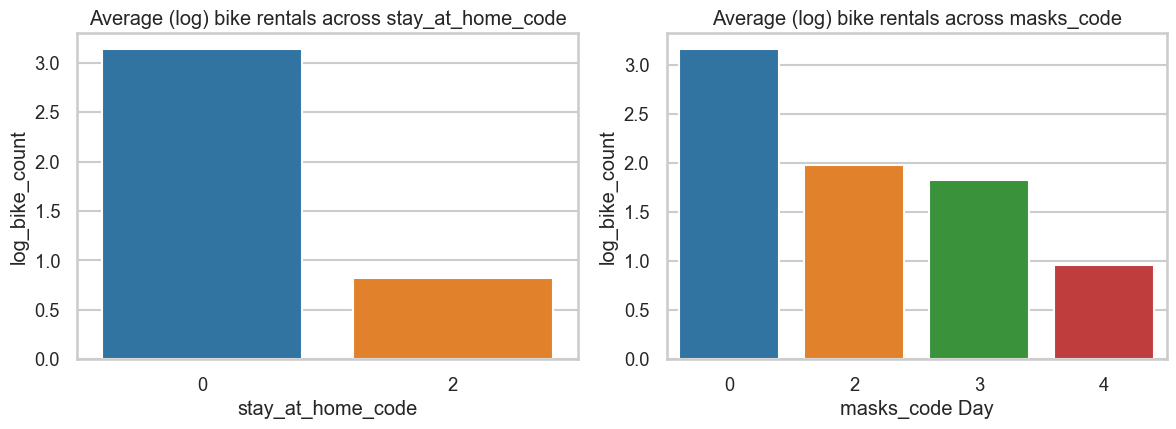

In [10]:
# Average values across each of the categorical columns 
fig = plt.figure(figsize=(12, 8))

axes = fig.add_subplot(2, 2, 1)
group_season = pd.DataFrame(bike_df.groupby(['stay_at_home_code'])['log_bike_count'].mean()).reset_index()
sns.barplot(data=group_season, x='stay_at_home_code', y='log_bike_count', ax=axes)
axes.set(xlabel='stay_at_home_code', ylabel='log_bike_count', title='Average (log) bike rentals across stay_at_home_code')

axes = fig.add_subplot(2, 2, 2)
group_workingday = pd.DataFrame(bike_df.groupby(['masks_code'])['log_bike_count'].mean()).reset_index()
sns.barplot(data=group_workingday, x='masks_code', y='log_bike_count', ax=axes)
axes.set(xlabel='masks_code Day', ylabel='log_bike_count', title='Average (log) bike rentals across masks_code')

plt.tight_layout()
plt.show()

In [11]:
# Look at the months with stay at home restrictions
filtered_bike_df = bike_df[bike_df['stay_at_home_code'] == 2]
filtered_bike_df['month'].unique()

array([10, 11, 12,  1,  2,  3,  4,  5,  6], dtype=int64)

#### Observations:

- Lockdown enforcement obviously has an impact on the number of bikes counted. We see these restrictions applied between October 2020 and June 2021. As we saw in the overall time series plot at the beginning, there was a big drop around October and January. This is most likely due to the lockdown restrictions on top of the fact that people tend to take the bike less during Winter season.

- Masks also played a role in the number of bikes seen in Paris. The stricter the rules, the less bikes were counted.

## Hourly Distribution

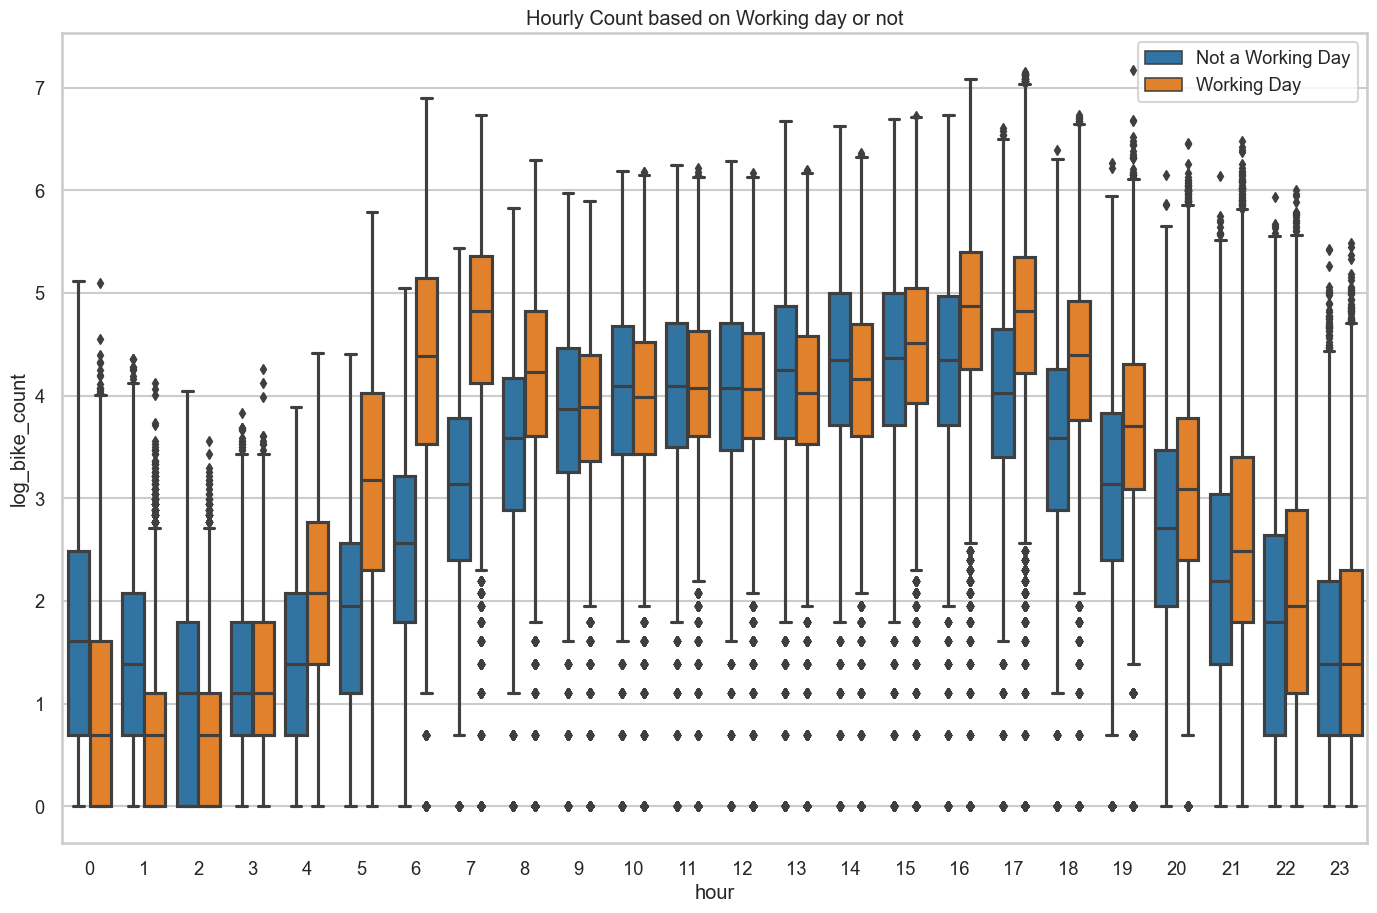

In [12]:
# seaborn boxplots across hours
f, axes = plt.subplots(1, 1, figsize=(15, 10))
sns.boxplot(data=bike_df, y='log_bike_count', x='hour', hue='working_day', ax=axes)
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
axes.set(title='Hourly Count based on Working day or not')

plt.show()

#### Observations:

We can see some pattern in the distribution. 

For example, during working days, people tend to rent bikes early in the morning (between 6am and 8am) and return them in the evening (between 4pm and 6pm).

However, during non-working days like the weekend, the pattern is slightly different. We see a slower increase in bike counts throughout the day (from 6am to 4pm) until it starts decreasing in the evening.


To get a different visualization, we can plot the average count per hour for variance categories (like the days of the week)

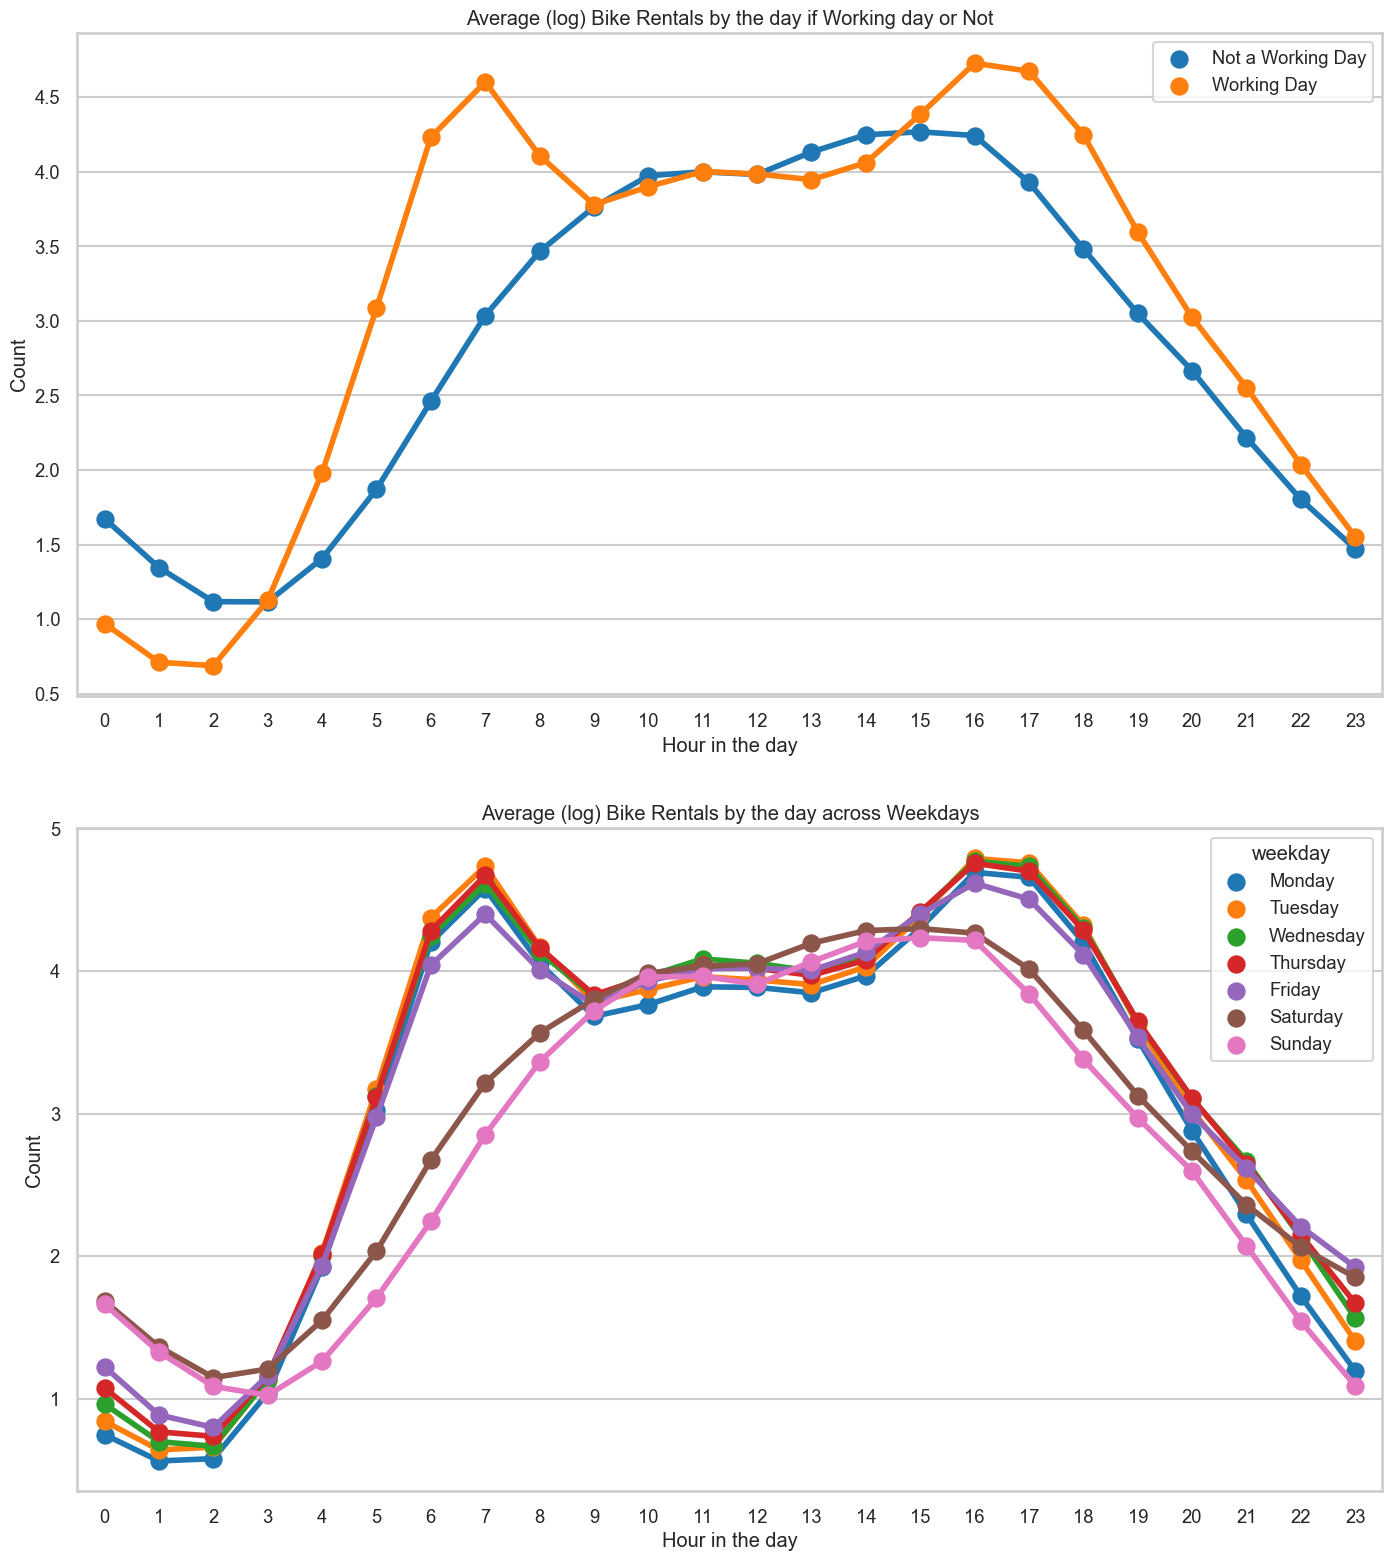

In [13]:
# Plots of average count across hour in a day for various categories

f, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 18))

group_work_hour = pd.DataFrame(bike_df.groupby(['working_day', 'hour'])['log_bike_count'].mean()).reset_index()

sns.pointplot(data=group_work_hour, x='hour', y='log_bike_count', hue='working_day', ax=axes[0])
handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Not a Working Day', 'Working Day'])
axes[0].set(xlabel='Hour in the day', ylabel='Count', title='Average (log) Bike Rentals by the day if Working day or Not')

# Assuming you have a dictionary to map the encoded weekdays to their names
weekday_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Map the 'weekday' column to its corresponding names
bike_df['weekday'] = bike_df['weekday'].map(weekday_mapping)

hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

group_day_hour = pd.DataFrame(bike_df.groupby(['weekday', 'hour'])['log_bike_count'].mean()).reset_index()

sns.pointplot(data=group_day_hour, x='hour', y='log_bike_count', hue='weekday', ax=axes[1], hue_order=hue_order)
axes[1].set(xlabel='Hour in the day', ylabel='Count', title='Average (log) Bike Rentals by the day across Weekdays')

plt.show()

#### Observations:

From the above plot we can see the 2 patterns across the hours in a day in bike rentals

- **Working Day:** We notice a peak of bikers at around 8am and another at around 5pm. These correspond to working local bikers who typically go to work on working day (Monday to Friday)

- **Non Working Day:** There is slower increase of bikers in the morning, with a peak in the early afternoon (2-3pm). These could correspond to tourists but seeing as our dataset is during the Covid period, it is quite unlikely. Another guess would be that it represents casual bikers who are using or renting bikes less early in the morning and more during the afternoon, and going out during the weekend when the weather is nicer. 

This more or less confirms our previous observation on the boxplots.

## Monthly Distribution

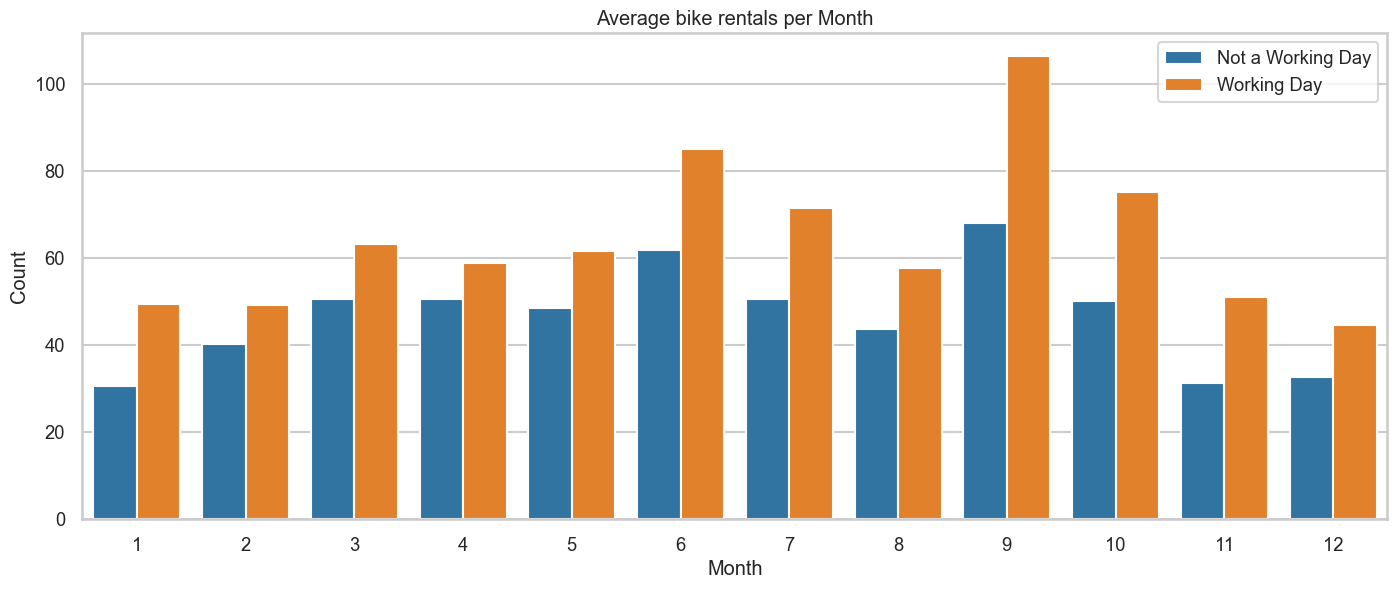

In [14]:
# Average Monthly Count Distribution plot
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
group_month = pd.DataFrame(bike_df.groupby(['month', 'working_day'])['bike_count'].mean()).reset_index()
sns.barplot(data=group_month, x='month', y='bike_count', hue='working_day', ax=axes)
axes.set(xlabel='Month', ylabel='Count', title='Average bike rentals per Month')
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
plt.show()

#### Observations:

We can see that we have more bikers during in June and in September. 

An explanation could be that the weather starts to get nicer around June, so more and more people start taking the bike to go to work. Similarly, in September, the temperature is still quite warm and starts to decrease in the later months, translating by a decrease in the number of bikers. However, we would need to explain why the number of bikers decreases in July and August. One reason could be because of school holidays, where families take care of their kids and prefer to use the car or easier transportation than the bike. Another reason is because our dataset has recordings from early September 2020 to early August 2021, hence our data in August is not as complete as the other months.

## Distribution vs. Temperature

As we saw before, there is a clear difference between working days and non working days. We will look at the impact of temperature on the number of bikes counted.

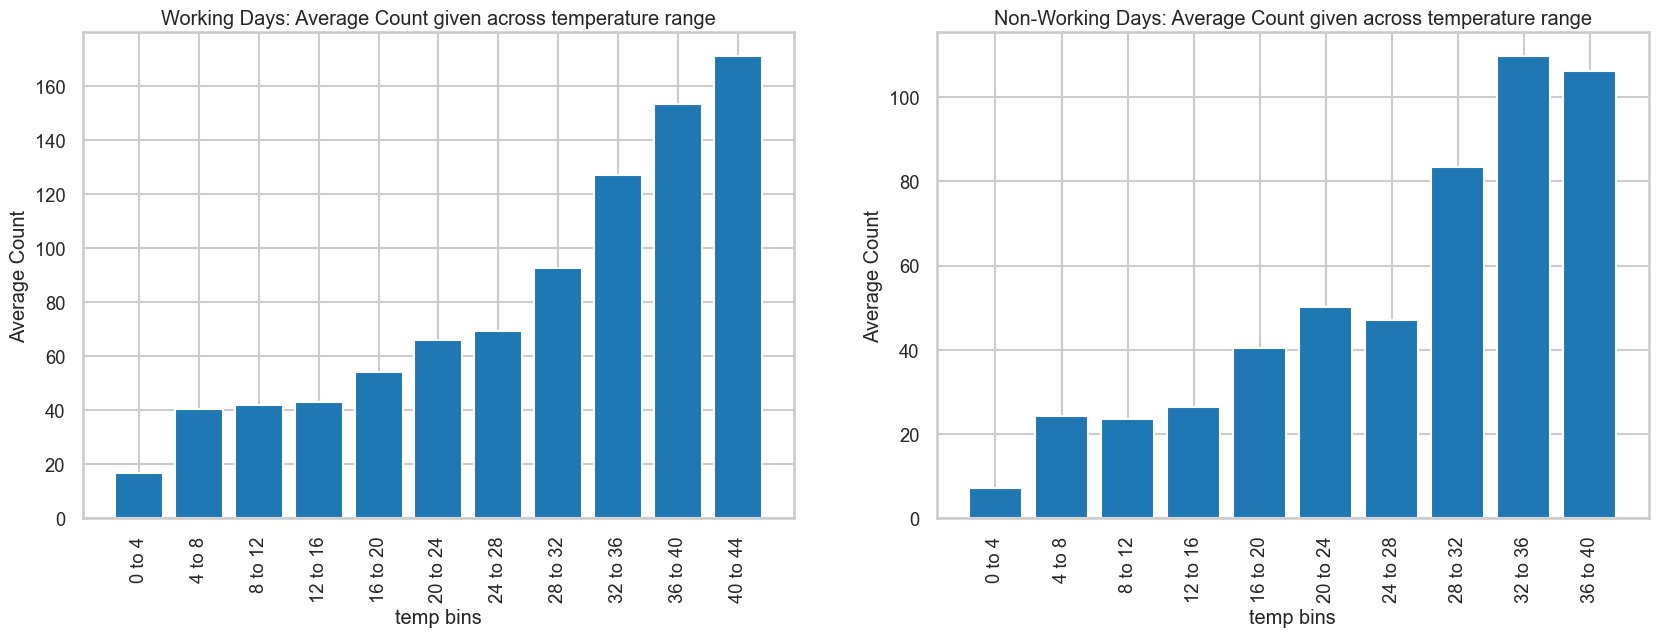

In [15]:
# Splitting data into working-day and non-working day
bike_df_work = bike_df[bike_df.working_day==1].copy()
bike_df_no_work = bike_df[bike_df.working_day==0].copy()

bin_size = 4
bike_df_work.loc[:, 'temp_round'] = bike_df_work['temp'] // bin_size
bike_df_no_work.loc[:, 'temp_round'] = bike_df_no_work['temp'] // bin_size

mean_count_vs_temp_w = bike_df_work.groupby('temp_round')['bike_count'].mean()
mean_count_vs_temp_nw = bike_df_no_work.groupby('temp_round')['bike_count'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Working Days: Average Count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Non-Working Days: Average Count given across temperature range')

plt.show()

#### Observation:

From the above histogram, we can see that there is a steady increase in the average bikes rented with temperature for both working days and non-working days.

## Outliers Analysis

Lastly, we can take a look at outliers, data entries with more than 3 standard deviation away from the mean.

In [16]:
bike_df_numerical = bike_df.select_dtypes(include=['int64', 'float64'])

# Threshold for Z-score beyond which a data point is considered an outlier (more than 3 std away from the mean)
z_threshold = 3  

# Compute Z-scores for each column in the DataFrame
z_scores = zscore(bike_df_numerical)

# Create a boolean mask indicating whether each data point is an outlier
outlier_mask = (abs(z_scores) > z_threshold).any(axis=1)

# Filter the DataFrame to remove outliers
bike_df_no_outliers = bike_df_numerical[~outlier_mask]

In [17]:
# Removing outliers from mydata
print('Shape of data before outliner pruning: ', bike_df_numerical.shape)
print('Shape of data after outlier pruning: ', bike_df_no_outliers.shape)
print('Number of outliers:', bike_df_numerical.shape[0] - bike_df_no_outliers.shape[0])

Shape of data before outliner pruning:  (496827, 17)
Shape of data after outlier pruning:  (444949, 17)
Number of outliers: 51878


We remove over 50,000 observations, which could seem like a lot, but we still have around 445,000 observations.

## Correlation Analysis

Finally, let's look at the correlation between our target variable `log_bike_count` and other numerical features.

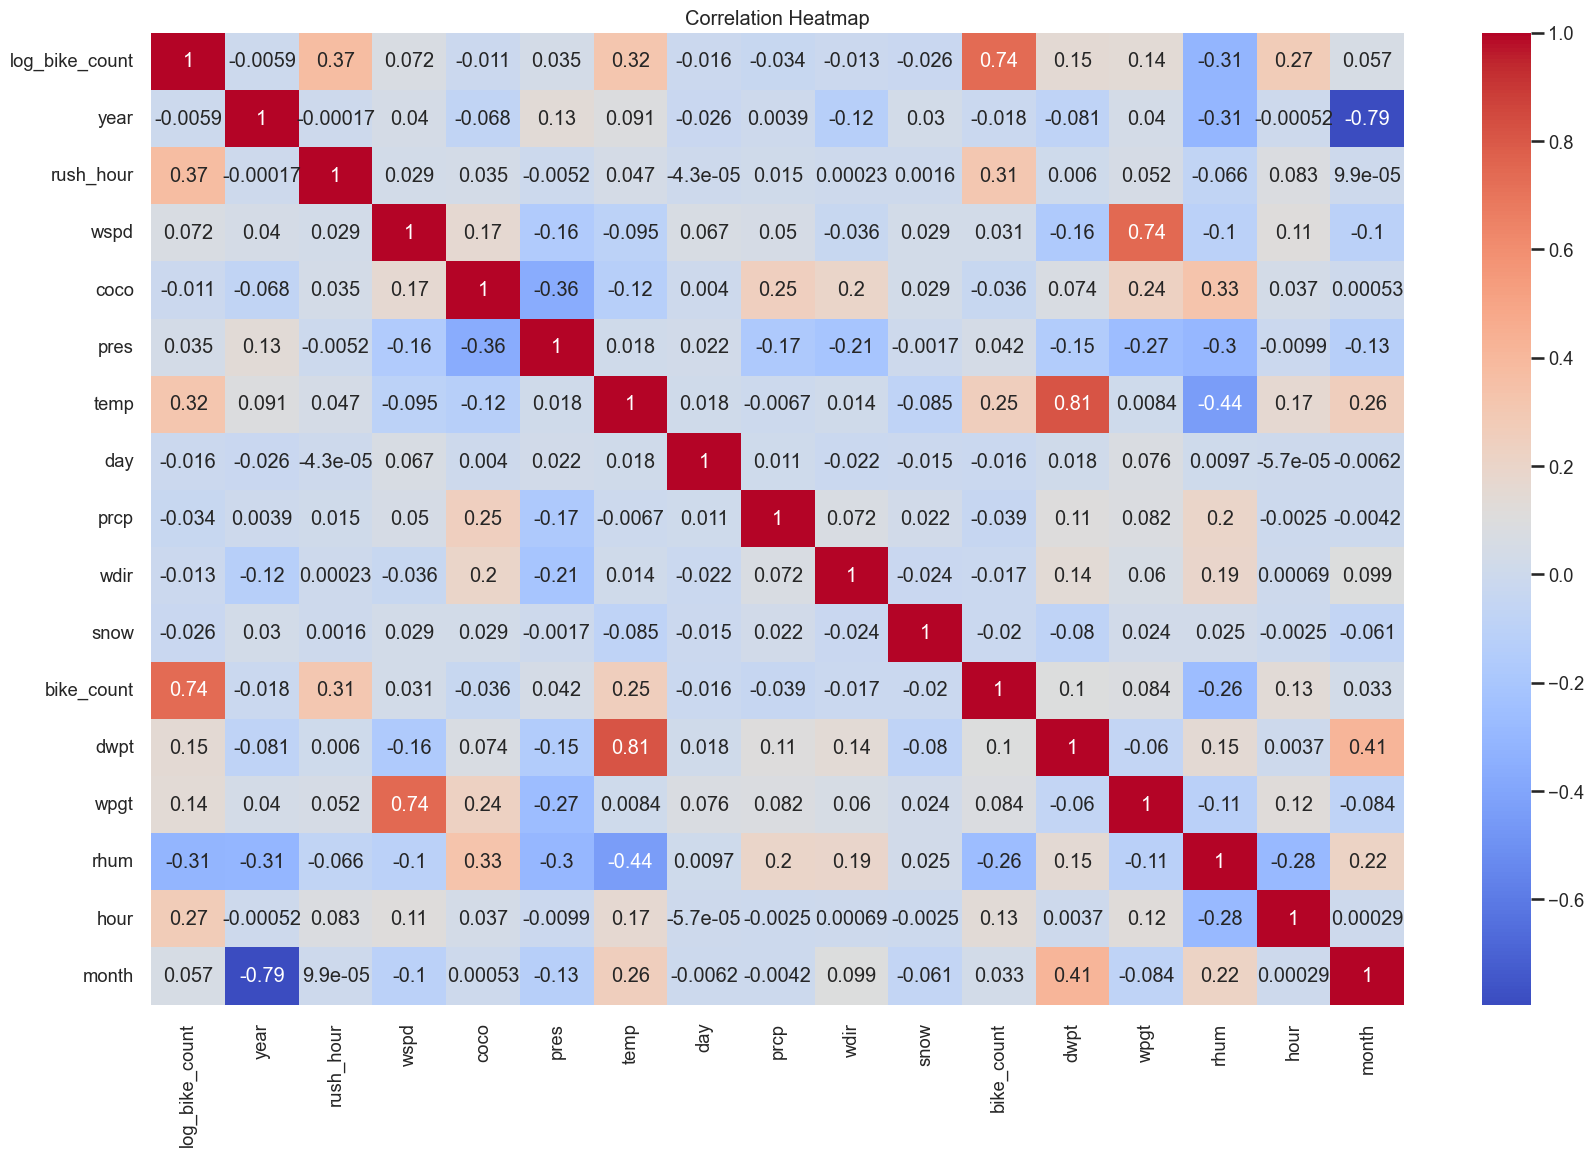

In [18]:
# To better read the correlation matrix, we will move the target variable (log_bike_count) to the first position
bike_df_numerical.insert(0, 'log_bike_count', bike_df_numerical.pop('log_bike_count'))

# Example correlation heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(bike_df_numerical.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show() 

#### Observations:

We are looking for two things: potential correlation between variables and more importantly, what variables have the highest correlation with our target variable `log_bike_count`

**Strong / Moderate Correlation with target:**
- We see a **strong positive correlation** between `log_bike_count` and `temperature`. People prefer to bike when the weather is warm (even hot).
- We see a **strong negative correlation** between `log_bike_count` and `humidity`. The more the humidity, the less people prefer to bike.
- We see a **strong positive correlation** between `log_bike_count` and `hour`. As expected, the time really influences on the number of bikes recorded (even more influence during `rush_hour`)
- We see a **moderate positive correlation** `log_bike_count` and `dwpt` (dew point) and `wpgt` (peak wind speed). 


**Correlation between variables:**
- `bike_count` and `log_bike_count` are **strongly** correlated.
- `year` and `month` are **strongly** correlated
- `temperature` and `dwpt` are **strongly** correlated.
- `wspd` and `wpgt` are **strongly** correlated.
- `temperature` and `humidity` are correlated.

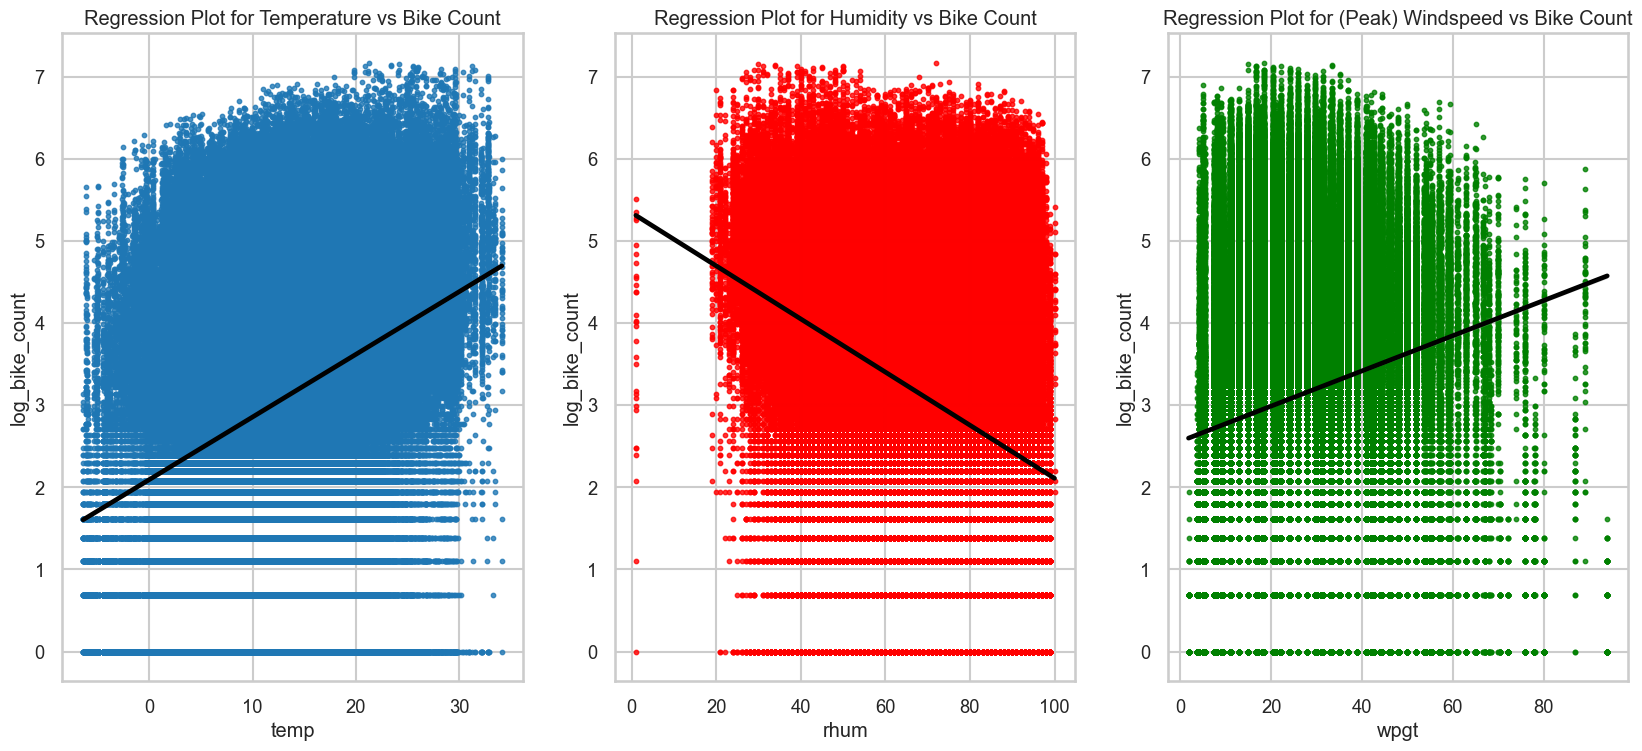

In [19]:
# Regression Plots with respect to Temperature, Humidity and Windspeed
fig = plt.figure(figsize=(18, 8))

axes = fig.add_subplot(1, 3, 1)
sns.regplot(data=bike_df, x='temp', y='log_bike_count',ax=axes, scatter_kws={'s': 10}, line_kws={'color': 'black'})
axes.set(title='Regression Plot for Temperature vs Bike Count')

axes = fig.add_subplot(1, 3, 2)
sns.regplot(data=bike_df, x='rhum', y='log_bike_count',ax=axes, color='red', scatter_kws={'s': 10}, line_kws={'color': 'black'})
axes.set(title='Regression Plot for Humidity vs Bike Count')

axes = fig.add_subplot(1, 3, 3)
sns.regplot(data=bike_df, x='wpgt', y='log_bike_count',ax=axes, color='green', scatter_kws={'s': 10}, line_kws={'color': 'black'})
axes.set(title='Regression Plot for (Peak) Windspeed vs Bike Count')

plt.show()

#### Observations:

The above regression plots indicate a **positive correlation** of our target variable `log_bike_count` with `temperature` and `windspeed` and a **negative correlation** with `humidity`.
It is quite surprising to see a positive correlation between `log_bike_count` and `windspeed`. It seems that as the peak wind speed increases, the bike count also increases.

# Conclusion:

Now that we have a better idea of which features have the biggest influence on our target variable `log_bike_count`, we can proceed to the next step: building the prediction model.